In [5]:
transacciones = [
    {"pan", "leche", "huevos", "café", "azúcar", "mantequilla"},
    {"cereal", "leche", "plátano", "yogurt", "miel"},
    {"arroz", "frijoles", "aceite", "sal", "pollo"},
    {"pan", "queso", "jamón", "mantequilla", "jugo"},
    {"fideos", "salsa de tomate", "queso", "pan"},
    {"café", "leche", "galletas", "azúcar"},
    {"huevos", "tocino", "pan", "jugo", "mantequilla"},
    {"yogurt", "manzanas", "granola", "miel"},
    {"arroz", "pollo", "aceite", "sal"},
    {"cereal", "leche", "pan"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan", "mantequilla"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "mantequilla", "café"},
    {"cereal", "leche", "jugo", "yogurt"},
    {"arroz", "frijoles", "pollo", "sal"},
    {"refresco", "papas fritas", "galletas"},
    {"jamón", "queso", "pan", "huevos"},
    {"huevos", "leche", "tocino", "pan"},
    {"yogurt", "granola", "miel"},
    {"jugo", "pan", "mantequilla", "queso"},
    {"cereal", "leche", "azúcar", "plátano"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"arroz", "pollo", "sal"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "huevos", "café", "azúcar"},
    {"yogurt", "manzanas", "miel"},
    {"cereal", "leche", "plátano"},
    {"pan", "queso", "jamón", "tomate"},
    {"galletas", "chocolate", "refresco"},
    {"arroz", "frijoles", "pollo", "sal"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "huevos", "café"},
    {"cereal", "leche", "yogurt"},
    {"huevos", "tocino", "pan", "jugo"},
    {"yogurt", "granola", "miel"},
    {"arroz", "pollo", "sal"},
    {"cereal", "leche", "jugo"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "leche", "mantequilla", "galletas"},
    {"cereal", "leche", "plátano", "miel"},
    {"arroz", "frijoles", "pollo"},
    {"galletas", "chocolate", "jugo"},
    {"queso", "jamón", "pan"},
    {"huevos", "tocino", "pan"},
    {"yogurt", "granola", "miel"},
    {"fideos", "salsa de tomate", "queso"},
    {"arroz", "pollo", "aceite", "sal"},
    {"jugo", "pan", "mantequilla"},
    {"cereal", "leche", "yogurt"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"pan", "huevos", "mantequilla"},
    {"arroz", "frijoles", "pollo"},
    {"cereal", "leche", "yogurt"},
    {"galletas", "chocolate", "refresco"},
    {"queso", "jamón", "pan"},
    {"fideos", "salsa de tomate", "queso"},
    {"café", "leche", "azúcar"},
    {"jugo", "galletas"},
    {"pan", "leche", "huevos"},
    {"arroz", "pollo"},
    {"cereal", "leche"},
    {"huevos", "pan"},
    {"galletas", "jugo"},
    {"jamón", "queso", "pan"},
    {"leche", "galletas"},
    {"yogurt", "manzanas"},
    {"pan", "queso"},
    {"huevos", "tocino"},
    {"arroz", "frijoles"},
    {"pan", "mantequilla", "miel"},
    {"refresco", "papas fritas"},
    {"cereal", "leche"},
    {"arroz", "pollo"},
    {"jugo", "manzanas"},
    {"jamón", "queso"},
    {"café", "leche"},
    {"manzanas", "jugo"},
    {"pan", "galletas"},
    {"huevos", "leche"},
    {"galletas", "chocolate"},
    {"pan", "mantequilla"},
    {"queso", "jamón"},
    {"cereal", "leche"},
]


Pregunta 6

In [27]:
from itertools import combinations
from collections import defaultdict

k = int(input("¿En cuántas transacciones desea que se muestren los conjuntos de productos? "))

def frequent_itemsets(transacciones, k):
    # Diccionario para contar la frecuencia de cada conjunto de items
    itemTrans = defaultdict(int)

    # Recorrer cada transacción en la lista de transacciones
    for t in transacciones:
        # Generar combinaciones de items con longitud entre 2 y 6
        for r in range(2, 7):  
            # Generar todas las combinaciones posibles de longitud 'r' de la transacción 't'
            for s in combinations(t, r):
                # Incrementar el contador para el conjunto de items (almacenado como frozenset)
                itemTrans[frozenset(s)] += 1

    # Diccionario para agrupar los conjuntos de items según su tamaño (número de elementos)
    agrupado = defaultdict(list)

    # Filtrar los conjuntos de items que tienen una frecuencia mayor o igual a 'k'
    for itemset, cant in itemTrans.items():
        if cant >= k:  
            # Agregar el conjunto de items al grupo correspondiente por tamaño
            agrupado[len(itemset)].append(set(itemset))
    
    # Devolver los conjuntos de items frecuentes agrupados por tamaño
    return agrupado

agrupados = frequent_itemsets(transacciones, k)
print(f"Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos {k} apariciones):")
for tamaño, s in sorted(agrupados.items()):
    print(f"\nConjuntos de tamaño {tamaño}:")
    for sub in s:
        print(sub)

Subconjuntos frecuentes agrupados por tamaño de conjunto (al menos 3 apariciones):

Conjuntos de tamaño 2:
{'pan', 'huevos'}
{'pan', 'café'}
{'pan', 'leche'}
{'pan', 'mantequilla'}
{'huevos', 'café'}
{'huevos', 'leche'}
{'huevos', 'mantequilla'}
{'café', 'azúcar'}
{'leche', 'azúcar'}
{'café', 'leche'}
{'leche', 'mantequilla'}
{'leche', 'plátano'}
{'cereal', 'plátano'}
{'yogurt', 'miel'}
{'yogurt', 'leche'}
{'yogurt', 'cereal'}
{'leche', 'cereal'}
{'arroz', 'aceite'}
{'pollo', 'aceite'}
{'sal', 'aceite'}
{'arroz', 'pollo'}
{'frijoles', 'arroz'}
{'arroz', 'sal'}
{'frijoles', 'pollo'}
{'pollo', 'sal'}
{'frijoles', 'sal'}
{'pan', 'jamón'}
{'jugo', 'pan'}
{'pan', 'queso'}
{'queso', 'jamón'}
{'jugo', 'mantequilla'}
{'queso', 'mantequilla'}
{'fideos', 'salsa de tomate'}
{'queso', 'salsa de tomate'}
{'fideos', 'queso'}
{'galletas', 'leche'}
{'pan', 'tocino'}
{'tocino', 'huevos'}
{'manzanas', 'yogurt'}
{'yogurt', 'granola'}
{'granola', 'miel'}
{'refresco', 'chocolate'}
{'refresco', 'galletas'}


Pregunta 7

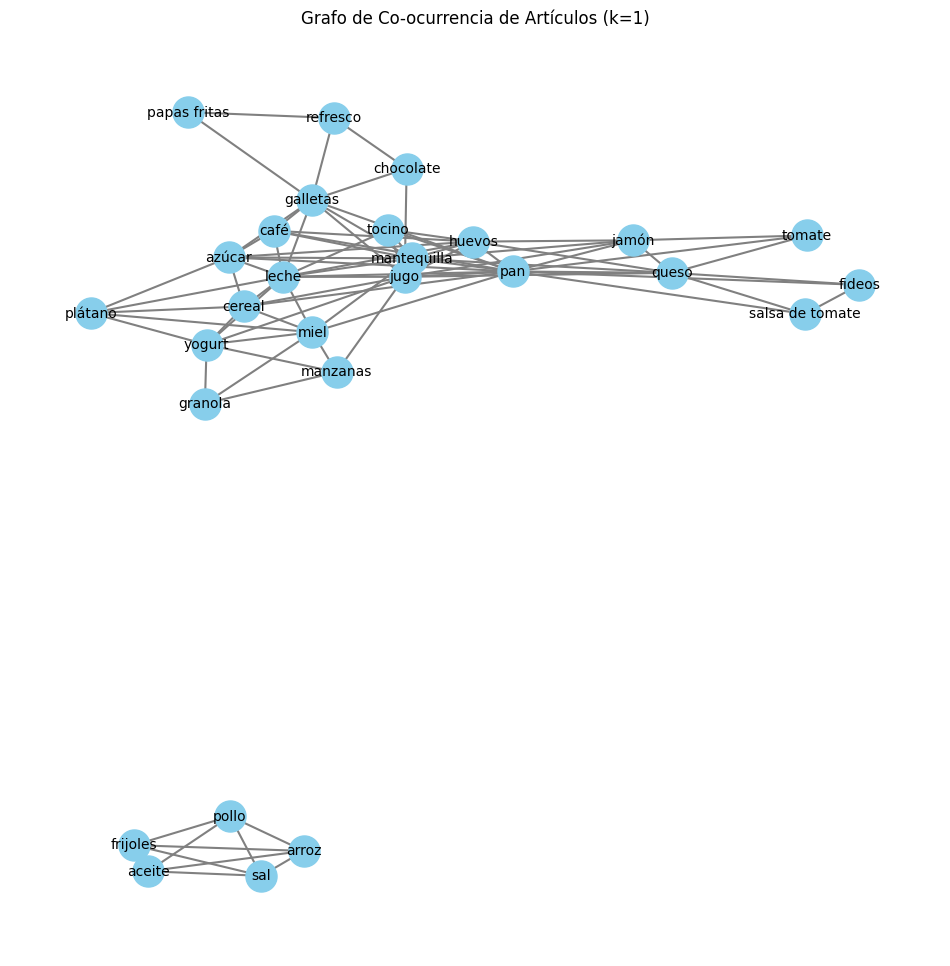

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import defaultdict

# Definir la función para construir el grafo de co-ocurrencia
def build_cooccurrence_graph(transacciones, k):
    co_ocurrencias = defaultdict(int)
    
    # Contar la co-ocurrencia de cada par de artículos en las transacciones
    for transaccion in transacciones:
        for item1, item2 in combinations(transaccion, 2):
            co_ocurrencias[frozenset([item1, item2])] += 1
    
    # Crear el grafo de co-ocurrencia
    grafo = nx.Graph()
    
    for (item1, item2), count in co_ocurrencias.items():
        if count >= k:
            grafo.add_edge(item1, item2)
    
    return grafo

# Ejemplo de uso
k = 1  # Umbral mínimo de co-ocurrencias
grafo_coocurrencia = build_cooccurrence_graph(transacciones, k)

# Visualizar el grafo
plt.figure(figsize=(12, 12))  # Definir el tamaño de la figura
pos = nx.spring_layout(grafo_coocurrencia, seed=42)  # Layout para la visualización

# Dibujar los nodos y aristas
nx.draw_networkx_nodes(grafo_coocurrencia, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(grafo_coocurrencia, pos, width=1.5, edge_color='gray')
nx.draw_networkx_labels(grafo_coocurrencia, pos, font_size=10, font_color='black', font_family='sans-serif')

# Título y ajuste de visualización
plt.title(f"Grafo de Co-ocurrencia de Artículos (k={k})")
plt.axis('off')  # Ocultar ejes
plt.show()

Pregunta 8

In [ ]:
from collections import defaultdict  
import networkx as nx  

# Función DFS (Depth-First Search) para explorar el grafo y encontrar los componentes conectados
def dfs(graph, start, visited):
    stack = [start]  
    component = set()  

    # Mientras haya nodos en la pila, continúa explorando
    while stack:
        node = stack.pop()  
        if node not in visited:  
            visited.add(node)  
            component.add(node)  

            # Agregar nodos adyacentes a la pila si no han sido visitados
            stack.extend(neighbor for neighbor in graph.neighbors(node) if neighbor not in visited)
    
    return component  

# Función para encontrar las comunidades (componentes conectados) en el grafo usando DFS
def find_communities_dfs(graph):
    visited = set()  
    communities = []  

    # Recorre todos los nodos del grafo
    for node in graph.nodes():
        if node not in visited:  
            component = dfs(graph, node, visited)  
            communities.append(component)  

    return communities  

# Configuración: Umbral de co-ocurrencia mínimo para construir el grafo
k = 2  

# Construcción del grafo de co-ocurrencia de artículos a partir de las transacciones
graph = build_cooccurrence_graph(transacciones, k)  

# Encuentra las comunidades de artículos que se compran juntos utilizando DFS
communities = find_communities_dfs(graph)

# Imprime las comunidades de artículos que suelen comprarse juntos
print("Comunidades de artículos que suelen comprarse juntos:")
for i, community in enumerate(communities, start=1):  
    print(f"Comunidad {i}: {community}") 


Comunidades de artículos que suelen comprarse juntos:
Comunidad 1: {'refresco', 'yogurt', 'granola', 'miel', 'manzanas', 'cereal', 'chocolate', 'jamón', 'azúcar', 'mantequilla', 'plátano', 'pan', 'papas fritas', 'jugo', 'queso', 'tocino', 'café', 'fideos', 'huevos', 'galletas', 'leche', 'salsa de tomate'}
Comunidad 2: {'arroz', 'frijoles', 'sal', 'pollo', 'aceite'}
